In [47]:
import ast
import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import torch

from transformers import AutoTokenizer, AutoModelWithLMHead

from sklearn.cluster import KMeans

import umap
from sklearn.manifold import TSNE

In [7]:
lyrics = pd.read_csv("../data/full.csv")

to_keep = ["track_name", "peak_pos", "album_name", "lyrics"]

lyrics = lyrics[to_keep]
lyrics['peak_pos_bucketed'] = lyrics['peak_pos'].apply(lambda x: '>100' if pd.isna(x) else str(int(x//10)*10) + '-' + str(int(x//10)*10 + 9))
lyrics.head()

,track_name,peak_pos,album_name,lyrics,peak_pos_bucketed
0,...Ready For It?,4.0,reputation,knew he was a killer first time that i saw him...,0-9
1,'tis the damn season,39.0,evermore,if i wanted to know who you were hanging with ...,30-39
2,"""Slut!"" (Taylor's Version) [From The Vault]",3.0,1989 (Taylor's Version),"flamingo pink, sunrise boulevard clink, clink,...",0-9
3,22,20.0,Red,it feels like a perfect night to dress up like...,20-29
4,22 (Taylor's Version),52.0,Red (Taylor's Version),it feels like a perfect night to dress up like...,50-59


In [8]:
# BERT for now, but I don't think it works too well
"""tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')"""


#This can be another model
tokenizer = AutoTokenizer.from_pretrained("huggingartists/taylor-swift")
model = AutoModelWithLMHead.from_pretrained("huggingartists/taylor-swift")

# This tokenizer doesn't have a padding token by default...
tokenizer.pad_token = tokenizer.eos_token


def encode_text(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
    
    with torch.no_grad(): 
        outputs = model(**inputs, output_hidden_states=True)

    embeddings = outputs.hidden_states[-1].mean(dim=1)
    #embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:1682: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [9]:
# https://huggingface.co/huggingartists/taylor-swift
lyrics['latent_embedding'] = lyrics['lyrics'].apply(lambda x: encode_text(x))

In [19]:
"""
This code is to be run to get the data from lyrics.csv in lieu of redoing all the embedding

Otherwise, DO NOT RUN
"""

lyricstest = pd.read_csv("../data/lyrics.csv")
lyricstest['latent_embedding'] = lyricstest['latent_embedding'].apply(lambda x: torch.tensor(ast.literal_eval(x)))
print(lyricstest.dtypes)
lyricstest.head()

track_name             object
peak_pos              float64
album_name             object
lyrics                 object
peak_pos_bucketed      object
latent_embedding       object
cluster_assignment      int64
dtype: object


,track_name,peak_pos,album_name,lyrics,peak_pos_bucketed,latent_embedding,cluster_assignment
0,...Ready For It?,4.0,reputation,knew he was a killer first time that i saw him...,0-9,"[tensor(-0.0335), tensor(0.6539), tensor(0.216...",6
1,'tis the damn season,39.0,evermore,if i wanted to know who you were hanging with ...,30-39,"[tensor(0.1974), tensor(0.4486), tensor(-0.253...",4
2,"""Slut!"" (Taylor's Version) [From The Vault]",3.0,1989 (Taylor's Version),"flamingo pink, sunrise boulevard clink, clink,...",0-9,"[tensor(-0.0312), tensor(0.5336), tensor(0.154...",0
3,22,20.0,Red,it feels like a perfect night to dress up like...,20-29,"[tensor(0.2236), tensor(0.6578), tensor(-0.195...",1
4,22 (Taylor's Version),52.0,Red (Taylor's Version),it feels like a perfect night to dress up like...,50-59,"[tensor(0.2230), tensor(0.7470), tensor(-0.246...",1


In [32]:
def plot_embeddings_interactive(embeddings, target_album=None, target_bucket=None):
    """
    This is a function so we can see if there are patterns among different buckets of billboard scores.
    It's a bit dizzying to look at everything overlaid...

    This plot is interactive to make encoding EDA not as painful
    """
    unique_albums = lyrics['album_name'].unique()
    album_colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_albums)))
    album_color_map = {album: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for album, col in zip(unique_albums, album_colors)}

    unique_buckets = lyrics['peak_pos_bucketed'].unique()
    peak_pos_colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_buckets)))
    peak_pos_color_map = {bucket: f'rgb({int(col[0]*255)}, {int(col[1]*255)}, {int(col[2]*255)})' for bucket, col in zip(unique_buckets, peak_pos_colors)}

    fig = go.Figure()

    # Ensuring embeddings_2d is a NumPy array for indexing
    embeddings_2d_np = np.array(embeddings)

    # Add traces for album names
    for album in unique_albums:
        if target_album is not None and target_album != album:
            continue
        idx = lyrics['album_name'] == album
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=album_color_map[album], opacity=0.7 if target_album is None or target_album == album else 0.2),
                                 name=album, text=lyrics[idx]['track_name']))

    # Add traces for peak position buckets, set to be initially hidden (visible on legend click)
    for bucket in unique_buckets:
        if target_bucket is not None and target_bucket != bucket:
            continue
        idx = lyrics['peak_pos_bucketed'] == bucket
        selected_embeddings = embeddings_2d_np[idx]
        fig.add_trace(go.Scatter(x=selected_embeddings[:, 0], y=selected_embeddings[:, 1],
                                 mode='markers', marker=dict(color=peak_pos_color_map[bucket], opacity=0.7 if target_bucket is None or target_bucket == bucket else 0.2),
                                 name=bucket, text=lyrics[idx]['track_name'],
                                 visible='legendonly'))

    fig.update_layout(title='Interactive Plot of Song Embeddings',
                      xaxis_title='TSNE 1',
                      yaxis_title='TSNE 2',
                      legend_title_text='Legend',
                      hovermode='closest')

    fig.show()

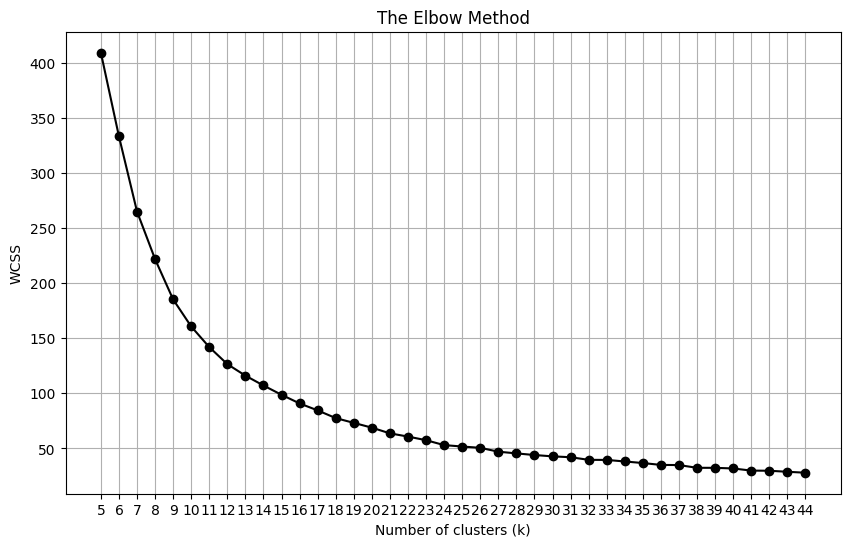

In [42]:
embeddings = np.array([embedding.flatten() for embedding in lyricstest['latent_embedding']])

# Number of components is arbitrary for now
ndims = 40
umap_reducer = umap.UMAP(n_components=ndims)
reduced_UMAP = umap_reducer.fit_transform(embeddings)

k_values = range(5, 45) 
wcss = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=256, n_init=10)
    kmeans.fit(reduced_UMAP)
    wcss.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, '-o', color='black')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [43]:
# Reducing with TSNE down to two dimensions to see if we can visually assess any separation?
tsne = TSNE(n_components=2, random_state=256)
embeddings_tsne_2d = tsne.fit_transform(reduced_UMAP)

plot_embeddings_interactive(embeddings_tsne_2d)

In [45]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=256, n_init=10).fit(embeddings)
lyrics['cluster_assignment'] = kmeans.labels_

Cluster 0: 41 members (12.54%)
Cluster 1: 26 members (7.95%)
Cluster 2: 9 members (2.75%)
Cluster 3: 26 members (7.95%)
Cluster 4: 5 members (1.53%)
Cluster 5: 28 members (8.56%)
Cluster 6: 21 members (6.42%)
Cluster 7: 20 members (6.12%)
Cluster 8: 34 members (10.40%)
Cluster 9: 24 members (7.34%)
Cluster 10: 31 members (9.48%)
Cluster 11: 9 members (2.75%)
Cluster 12: 20 members (6.12%)
Cluster 13: 7 members (2.14%)
Cluster 14: 26 members (7.95%)


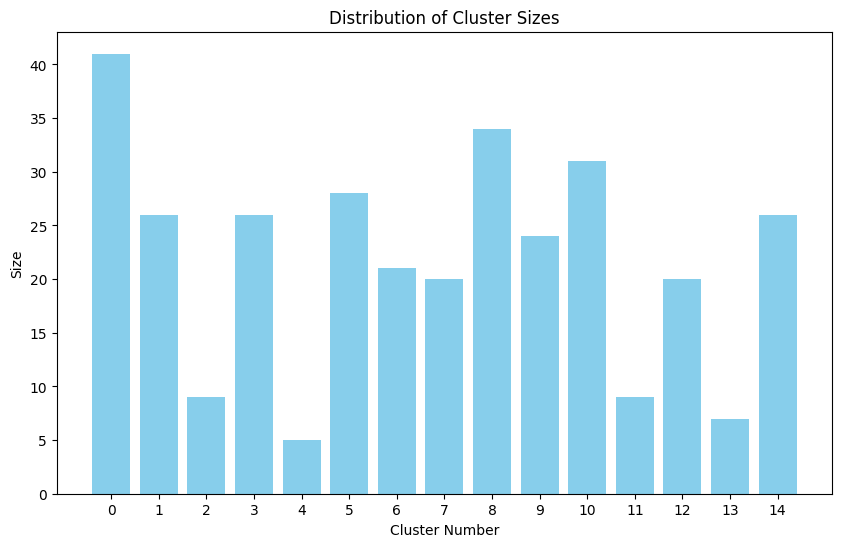

In [51]:
cluster_sizes = Counter(lyrics['cluster_assignment'])

sorted_cluster_sizes = dict(sorted(cluster_sizes.items()))

total_items = sum(sorted_cluster_sizes.values())
for label, size in sorted_cluster_sizes.items():
    percentage = (size / total_items) * 100
    print(f"Cluster {label}: {size} members ({percentage:.2f}%)")

labels, sizes = zip(*sorted(cluster_sizes.items()))

plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color='skyblue')
plt.title('Distribution of Cluster Sizes')
plt.xlabel('Cluster Number')
plt.ylabel('Size')
plt.xticks(labels)
plt.show()

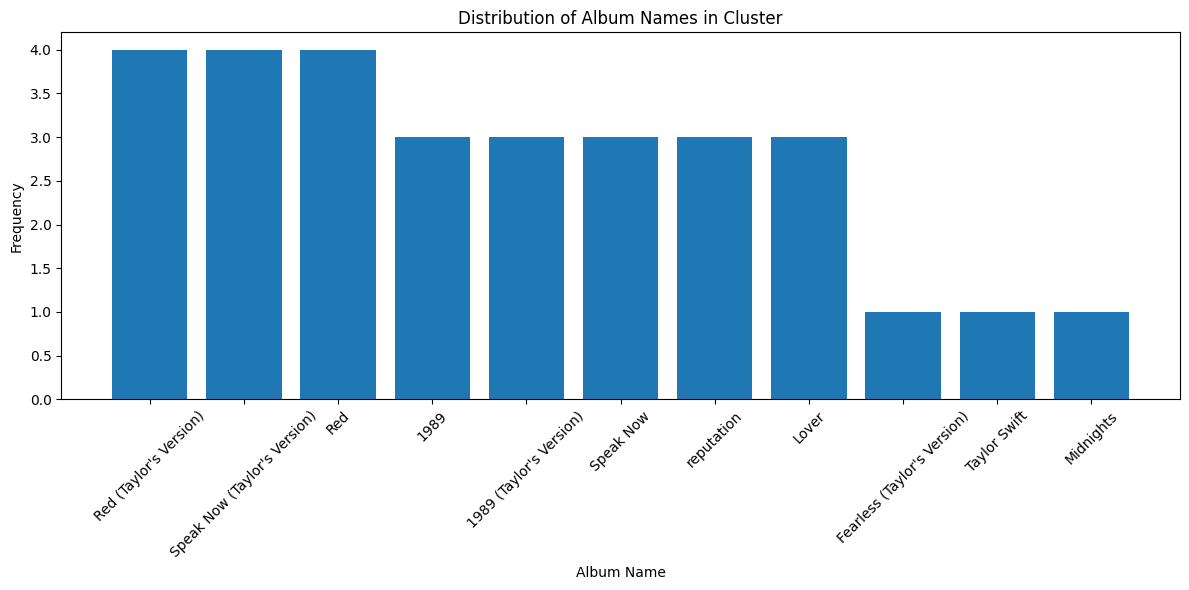

/var/folders/fs/v9vqgp9d5zb2fzzy63_b2gcr0000gn/T/ipykernel_11983/1566498833.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



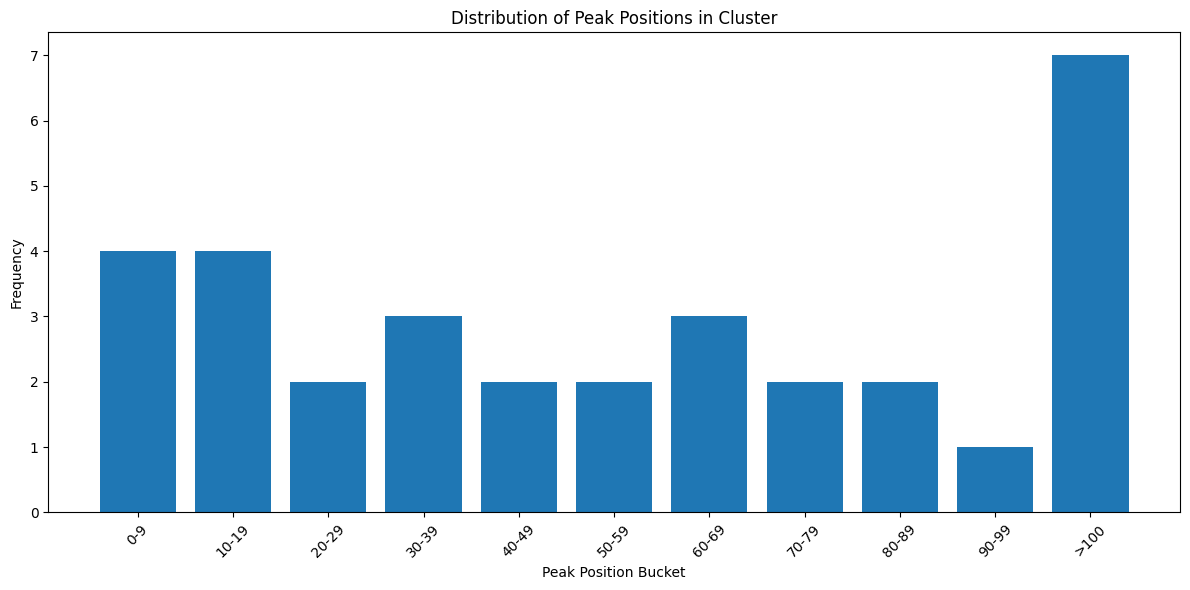

In [14]:
c = 5
clusters = lyrics[lyrics["cluster_assignment"] == c]

# Plotting the distribution for 'album_name'
plt.figure(figsize=(12, 6))
album_name_counts = clusters['album_name'].value_counts()
plt.bar(album_name_counts.index, album_name_counts.values)
plt.xlabel('Album Name')
plt.ylabel('Frequency')
plt.title('Distribution of Album Names in Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the distribution for 'peak_pos'
plt.figure(figsize=(12, 6))

# Handling NaN values by categorizing them as >100
clusters['peak_pos_bucketed'] = clusters['peak_pos'].apply(lambda x: '>100' if pd.isna(x) else str(int(x//10)*10) + '-' + str(int(x//10)*10 + 9))

# Counting values in each bucket including the '>100' category
peak_pos_counts = clusters['peak_pos_bucketed'].value_counts().sort_index()

plt.bar(peak_pos_counts.index, peak_pos_counts.values)
plt.xlabel('Peak Position Bucket')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Positions in Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Convert latent embedding to something that is readable when we load the csv
#lyrics['latent_embedding'] = lyrics['latent_embedding'].apply(lambda x: [t.item() for t in x[0]])
# No need to run the above line again unless you re-encode the songs


lyrics.to_csv("../data/lyrics.csv", index=False)